In [1]:
import numpyro
numpyro.set_host_device_count(4)
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

import warnings
warnings.filterwarnings('ignore', message='The RandomType SharedVariables')
warnings.filterwarnings('ignore', message='Skipping `CheckAndRaise` Op')

plt.rcParams.update({
    'figure.figsize': (14, 4),
    'figure.dpi': 144,
    'axes.grid': True,
    'grid.linewidth': 0.5,
    'grid.linestyle': '--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False,
    'figure.constrained_layout.use': True
})

import numpy as np
seed = sum(map(ord, 'LEGO as a Modeling Philosophy'))
rng = np.random.default_rng()

In [2]:
def plot_timeseries_posterior(idata, data=None, ax=None, color='tab:blue', data_color='k', label=None):
    if ax is None:
        fig, ax = plt.subplots()

    mu = idata.mean(dim=['chain', 'draw'])
    hdi = az.hdi(idata)
    key = list(hdi.data_vars.keys())[0]
    hdi = hdi[key]
    
    x_values = mu.coords['time'].values

    ax.plot(x_values, mu, color=color, label=label)
    ax.fill_between(x_values, *hdi.values.T, alpha=0.25, color=color, label=f'{label} HDI 94%' if label is not None else None)
    
    if data is not None:
        ax.plot(x_values, data, color=data_color, ls='--', label='Data')
    
    if label is not None:
        ax.legend()
    
    return ax

In [3]:
from pymc_marketing.mmm.delayed_saturated_mmm import MMM
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]

# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)

# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + df["epsilon"]
)

data = df[[
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
#     "dayofyear",
]]

df['beta_event_1'] = 1.5
df['beta_event_2'] = 2.5
df['beta_x1'] = beta_1
df['beta_x2'] = beta_2

data = data.rename(columns={'date_week':'date'}).set_index('date')
data.index.freq = data.index.inferred_freq

df = df.rename(columns={'date_week':'date'}).set_index('date')
df.index.freq = df.index.inferred_freq


/Users/jessegrabowski/mambaforge/envs/statespace/lib/python3.12/site-packages/pytensor/tensor/random/op.py:84: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/jessegrabowski/mambaforge/envs/statespace/lib/python3.12/site-packages/pytensor/tensor/random/op.py:94: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


# Structural Modeling

The last major class ready-to-go model in the `statespace` submodule are structural time series decomposition. These are a set of components that live in `pymc_experimental.statespace.structural`. Available options are:

- `LevelTrendComponent`
- `TimeSeasonality`
- `FrequencySeasonality`
- `CycleComponent`
- `AutoregressiveComponent`
- `RegressionComponent`
- `MeasurementError`

In [4]:
from pymc_experimental.statespace import structural as st

## Model Definition

A structural model is constructed by adding together several structural components. Much like GPs, statespace model can be created by combinations of smaller statespace models. This is principle of the `structural` module.

First, create the individual components you want to include in your model. For example, to create a Gaussian Random Walk with measurement error, we can compose a `LevelTrendComponent` of order 1 with a `MeasurementError` component: 

In [48]:
grw = st.LevelTrendComponent(order=1, innovations_order=1)
me = st.MeasurementError()

print(type(grw))
print(type(me))

<class 'pymc_experimental.statespace.models.structural.LevelTrendComponent'>
<class 'pymc_experimental.statespace.models.structural.MeasurementError'>


Then, a new model can be created by adding these together. The result is still a component, not a full `PyMCStateSpaceModel`.

In [51]:
gre_with_me = grw + me
print(type(gre_with_me))

<class 'pymc_experimental.statespace.models.structural.Component'>


At any point, a single component or a composition of components can be promoted to a model. To do this, use the `.build` method. Once the build method is called, you will get the usual info dump about what you need to declare inside a PyMC model.

In [53]:
ss_mod = gre_with_me.build()

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (1,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (1,), constraints: Positive, dims: ('trend_shock',)
	sigma_MeasurementError -- shape: (), constraints: Positive, dims: None
	P0 -- shape: (1, 1), constraints: Positive semi-definite, dims: ('state', 'state_aux')
INFO:pymc.experimental.statespace:The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (1,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (1,), constraints: Positive, dims: ('trend_shock',)
	sigma_MeasurementError -- shape: (), constraints: Positive, dims: None
	P0 -- shape: (1, 1), constraints: Positive semi-definite, dims: ('state', 'state_aux')


Each component can create differernt types of patterns. For an exhaustive walkthrough of each component, check out this tutorial:

https://github.com/pymc-devs/pymc-experimental/blob/main/notebooks/Structural%20Timeseries%20Modeling.ipynb

# Applied Example: Marketing and Sales

For this presentation, lets see how we can use the lego blocks approach to model data that has 1) trend, 2) seasonality, and 3) outside influences. I use generated data taken from the PyMC-Marketing tutorial here:

https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html

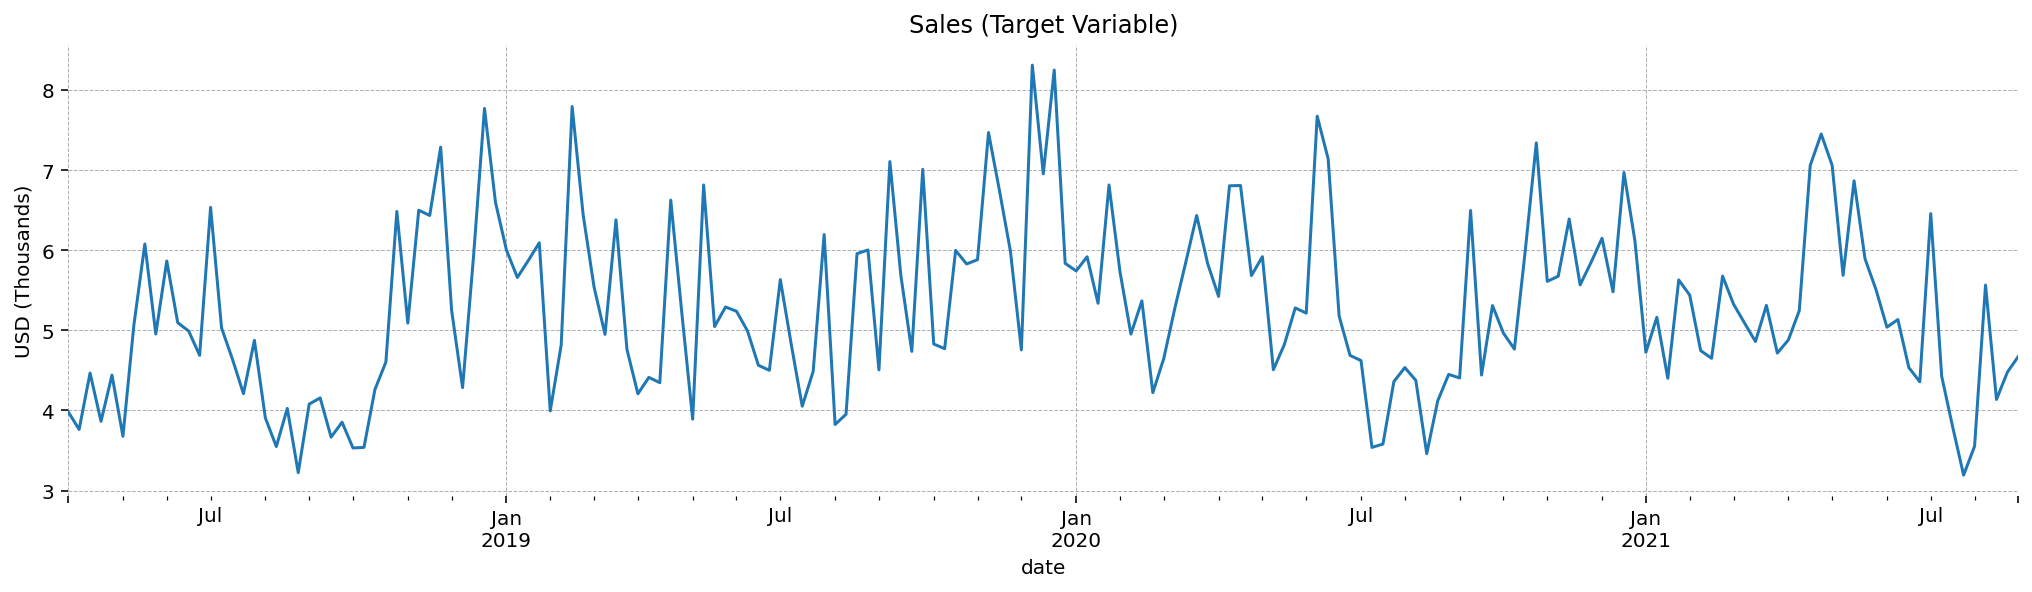

In [5]:
data.y.plot(title = 'Sales (Target Variable)', ylabel='USD (Thousands)');

Here are the exogenous features we will include. These will *not* be modeled as time series. Instead, we will use the `RegressionComponent` to bring them in as totally exogenous factors.

Brining in exogenous data can be good or bad. On one hand, we might want to model control variables (like advertising spend) as external forces that act on the model. On the other hand, the price of this is that we can no longer make forward regressions by simply iterating on the time series dynamics.

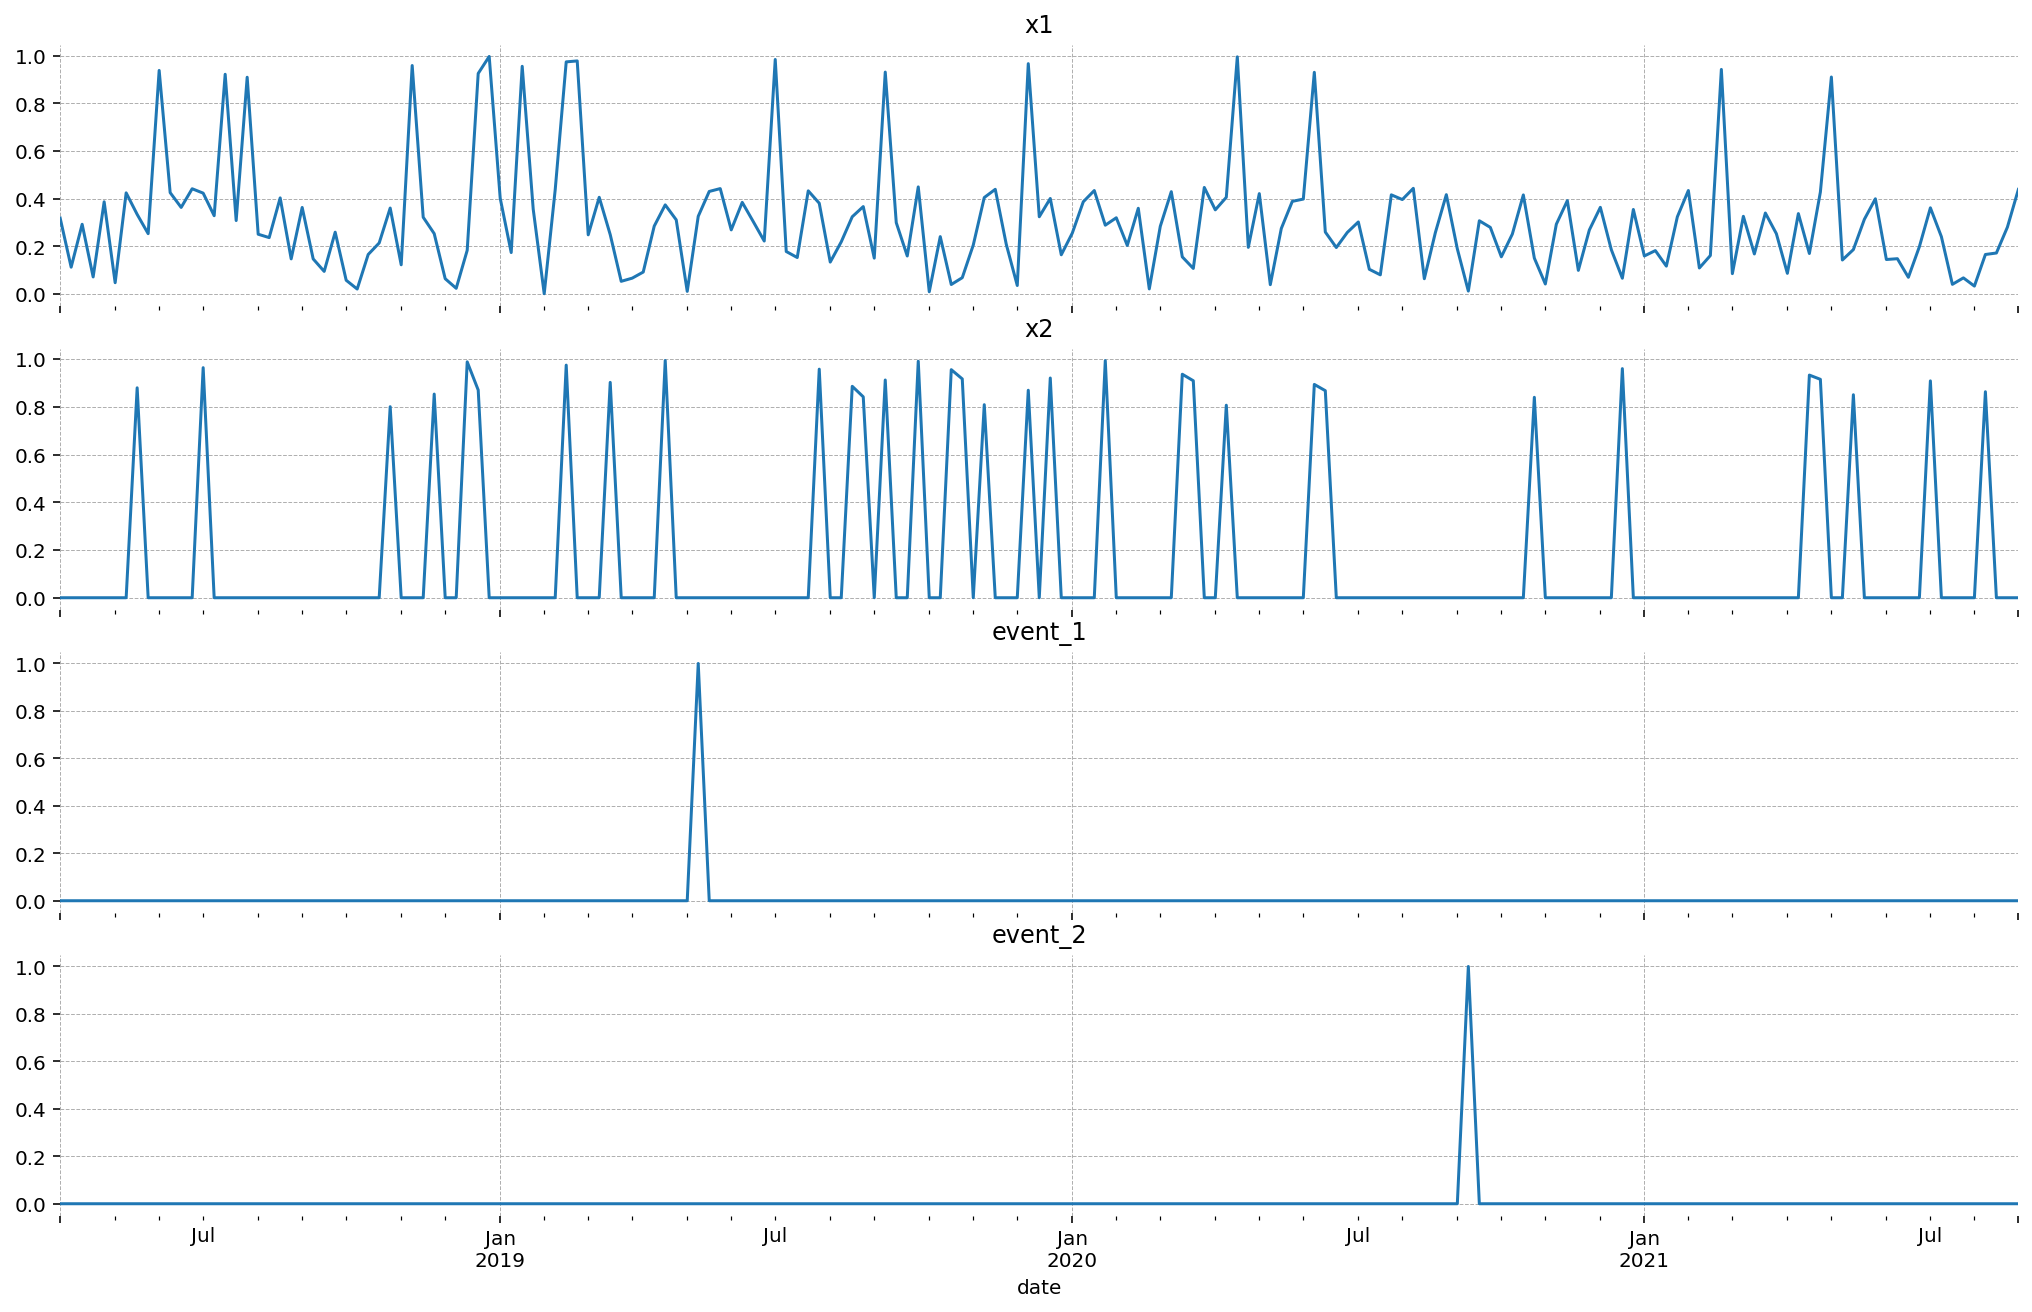

In [6]:
fig, ax = plt.subplots(4, figsize=(14, 9), sharex=True)
for axis, name in zip(fig.axes, ['x1', 'x2', 'event_1', 'event_2']):
    data[name].plot(ax=axis, title=name)

In [7]:
y = data['y']
X = data.drop(columns='y')

For this model, we will use the following components:

- `LevelTrendComponent(order=2, innovations_order=[0, 1])`. This is a very smooth type of trend model, where the level is fixed, and the velocity (the first derivaive of the level) is allowed to slowly change. 
- `FrequencySeasonality(season_length=52, n=2)`. We will use a year-long seasonal effect. `n=2` means that we will include two fourier bases in our model. This will allow for a long and medium cycle. When `n = seasonal_length/2`, the fourier features can create any shape. When `n << seasonal_length / 2`, we restrict ourselves to simple wave-like patterns. We set `innovations=False` so that the seasonal effect is fixed and doesn't vary over time.
- `RegressionComponent`, this is where we introduce the ad spending and event data. We set `innovations=False` to rule out time-varying effects.
- `MeasurementError`, this is an iid white noise over the data. If we don't include this, we are are assuming that *only* stochastic innovations from the time series components drive variations in the data.

After building these components, we call `.build()`.

In [8]:
slow_trend = st.LevelTrendComponent(order=2, innovations_order=[0, 1])
seasonality = st.FrequencySeasonality(name='annual_seasonality',
                                      season_length=52,
                                      n=2, 
                                      innovations=False)
exog = st.RegressionComponent(name='exog', state_names=X.columns.tolist(), innovations=False)
measurement_error = st.MeasurementError('measurement_error')
ss_mod = (slow_trend + seasonality + exog + measurement_error).build()

The following parameters should be assigned priors inside a PyMC model block: 
	initial_trend -- shape: (2,), constraints: None, dims: ('trend_state',)
	sigma_trend -- shape: (1,), constraints: Positive, dims: ('trend_shock',)
	annual_seasonality -- shape: (4,), constraints: None, dims: ('annual_seasonality_state',)
	beta_exog -- shape: (4,), constraints: None, dims: ('exog_state',)
	sigma_measurement_error -- shape: (), constraints: Positive, dims: None
	P0 -- shape: (10, 10), constraints: Positive semi-definite, dims: ('state', 'state_aux')
The following Data variables should be assigned to the model inside a PyMC model block: 
	data_exog -- shape: (None, 4), dims: ('time', 'exog_state')


Notice a message we've never seen before -- we are now told that the model requires exogenous data, so we're instructed to add a `pm.Data` container called `data_exog`. This will be important later when we do scenario-based forecasting.

In [45]:
with pm.Model(coords=ss_mod.coords) as struct_model:
    # Level and Trend block
    initial_trend = pm.Normal('initial_trend', mu=[0, 1e-3], sigma=[2, 1e-4], dims=['trend_state'])
    sigma_trend = pm.Exponential('sigma_trend', lam=1000, dims=['trend_shock'])
    
    # Seasonality
    annual_seasonality = pm.Normal('annual_seasonality', mu=0, sigma=3, dims=['annual_seasonality_state'])
    
    # Exogenous regression
    data_exog = pm.Data('data_exog', X.values, dims=['time', 'exog_state'])
    beta_exog = pm.Normal('beta_exog', mu=0, sigma=3, dims=['exog_state'])
        
    # Measurement error
    sigma_measurement_error = pm.Exponential('sigma_measurement_error', lam=10)
        
    P0_diag = pm.Exponential('P0_diag', lam=10, dims='state')
    P0 = pm.Deterministic('P0', pt.diag(P0_diag), dims=['state', 'state_aux'])
    
    ss_mod.build_statespace_graph(y, mode='JAX')

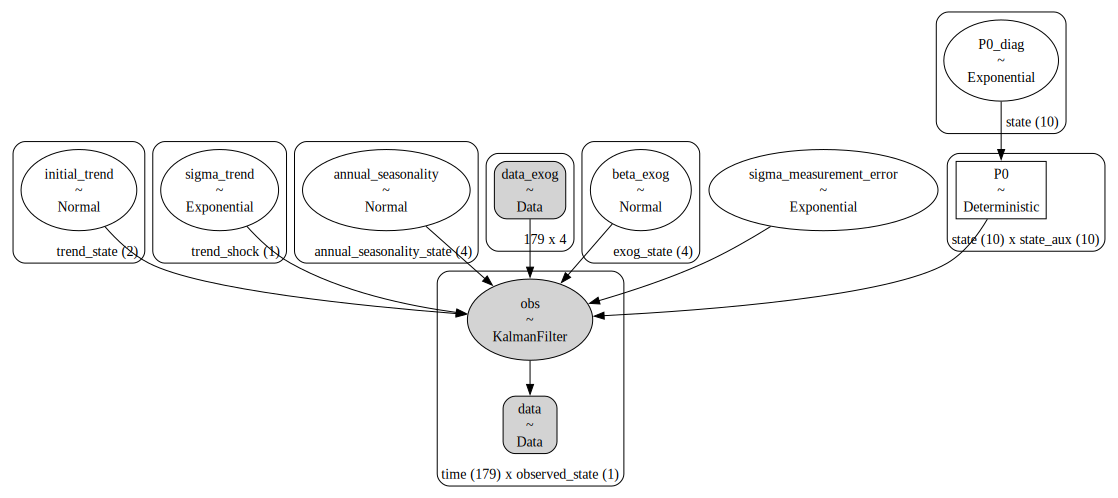

In [46]:
struct_model.to_graphviz()

# Model Fitting and Diagnostics

In [ ]:
with struct_model:
    idata = pm.sample(nuts_sampler='numpyro')

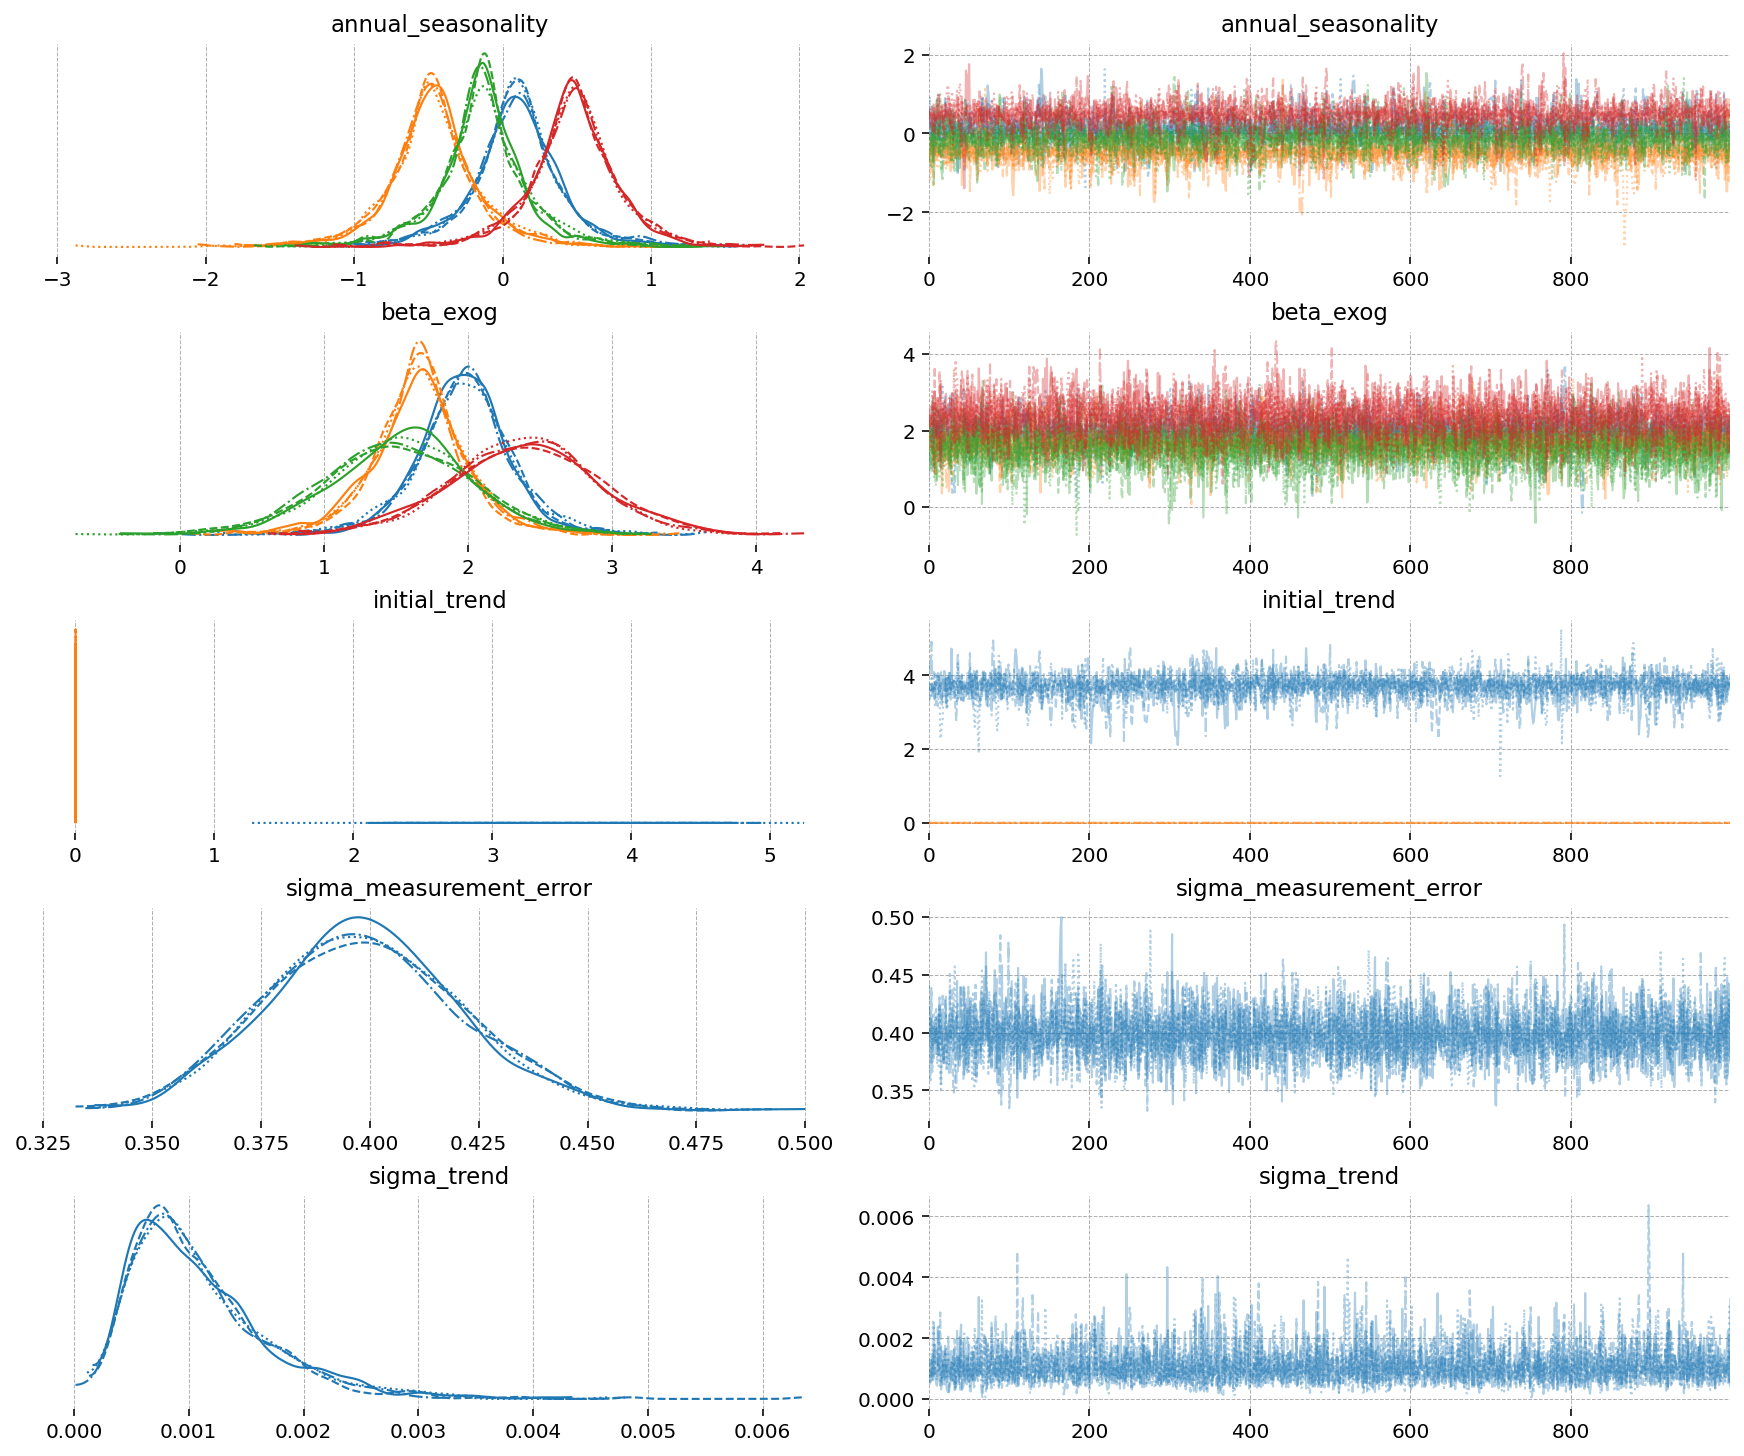

In [10]:
az.plot_trace(idata, var_names=['~P0', '~P0_diag']);

## In-Sample Posterior Forecasts 

In [11]:
idata_post = ss_mod.sample_conditional_posterior(idata)

Sampling: [filtered_posterior, filtered_posterior_observed, predicted_posterior, predicted_posterior_observed, smoothed_posterior, smoothed_posterior_observed]


Output()

<Axes: >

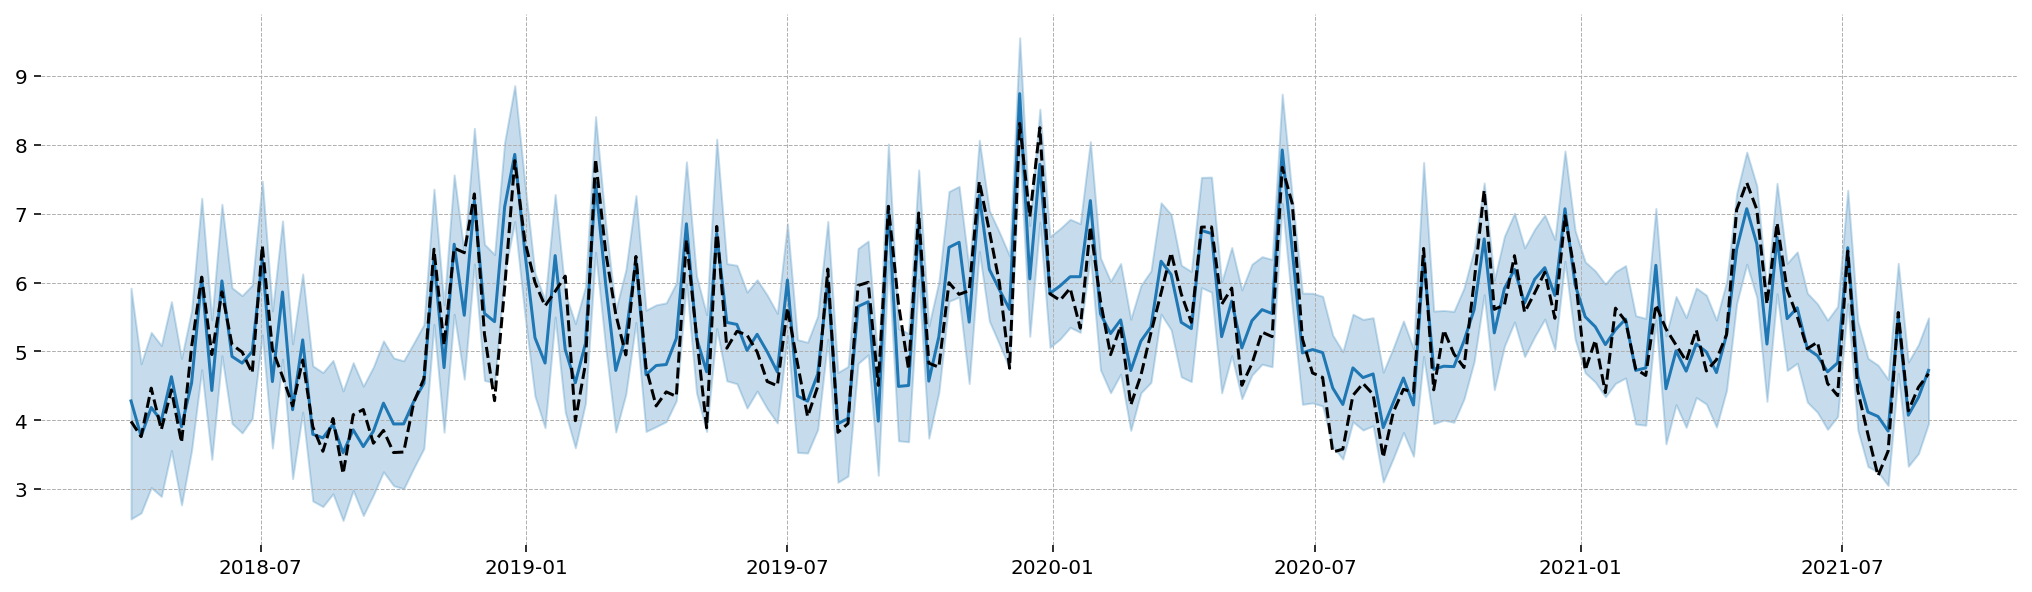

In [12]:
plot_timeseries_posterior(idata_post.predicted_posterior_observed.isel(observed_state=0), data=data.y)

## Component Decomposition

Since structural models are built of many sub-components, we are probably interested in what each of those components contributes to the final prediction. 

Statespace models created by the `build()` method have a special `extract_components_from_idata` method. It takes a post-estimation output (conditional, unconditonal, or forecast) and modifies the `state` coordinate so that there is one state per element.

In [13]:
idata_components = ss_mod.extract_components_from_idata(idata_post)
idata_components.coords['state'].values

Variables filtered_posterior_observed, predicted_posterior_observed, smoothed_posterior_observed do not contain all hidden states (their last dimension is not 10). They will not be present in the modified idata.


array(['LevelTrend[level]', 'LevelTrend[trend]', 'annual_seasonality',
       'exog[x1]', 'exog[x2]', 'exog[event_1]', 'exog[event_2]'],
      dtype='<U18')

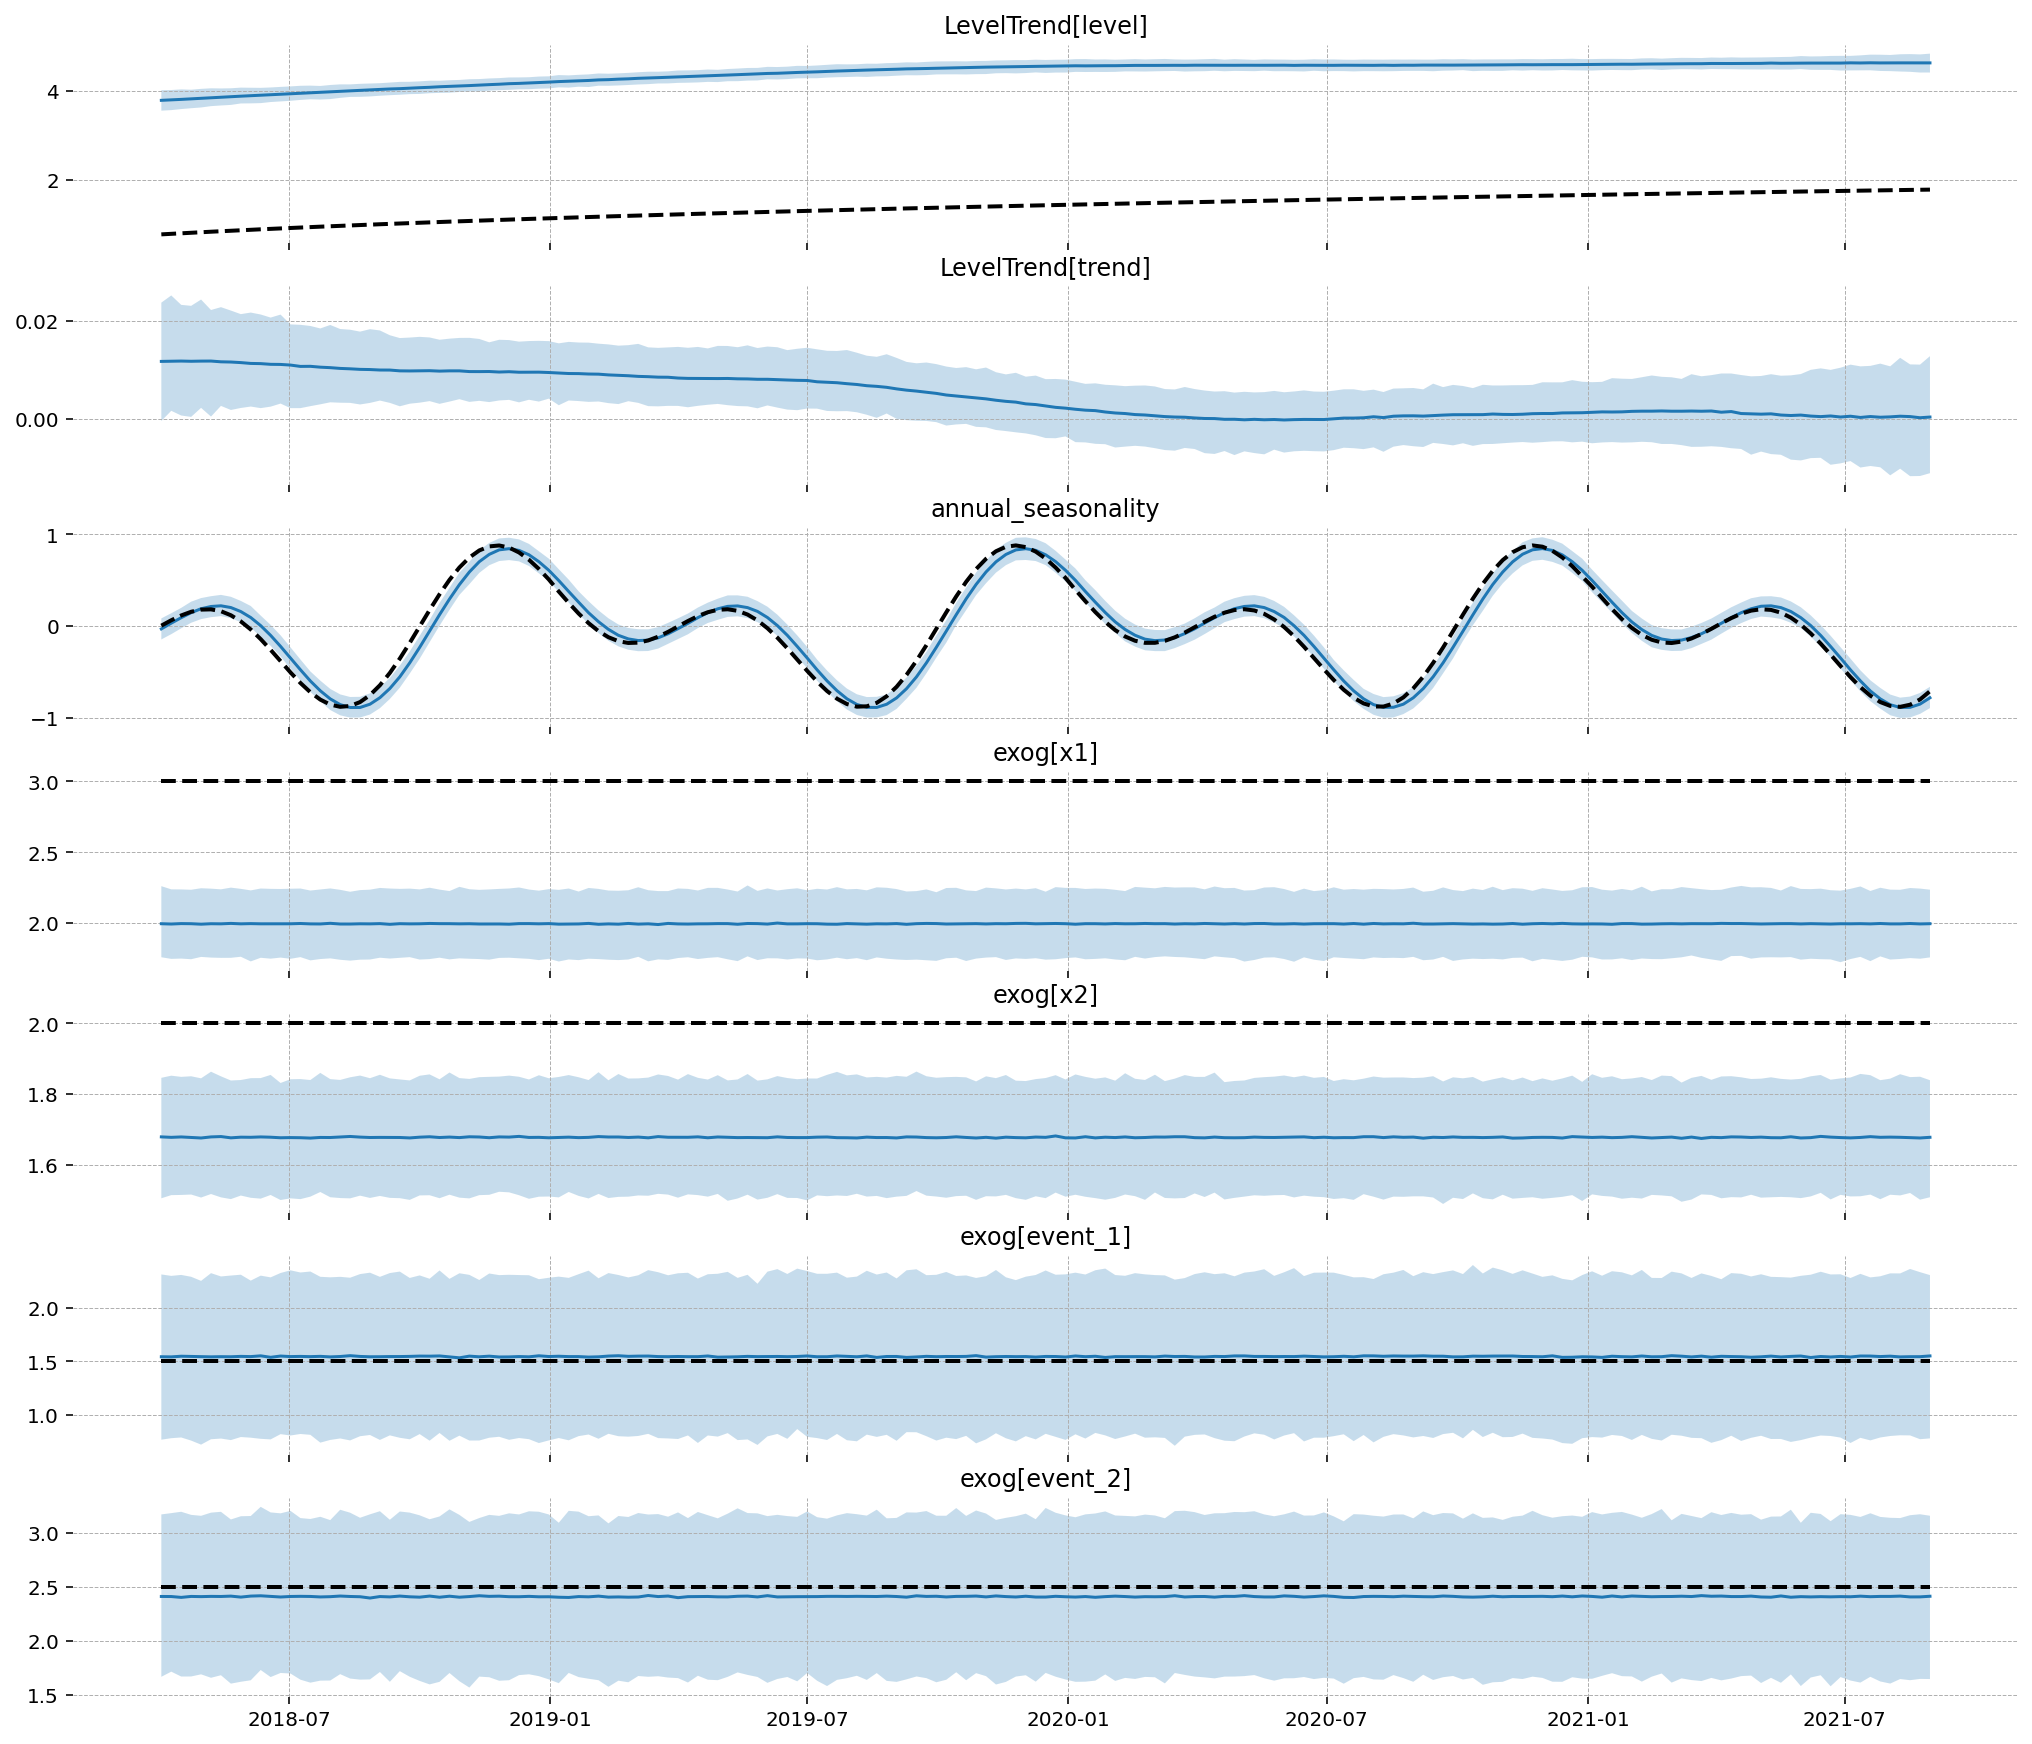

In [14]:
fig, ax = plt.subplots(7, 1, figsize=(14, 12), sharex=True)
component_truth = {
    'LevelTrend[level]': df['trend'],
    'annual_seasonality': df['seasonality'],
    'exog[x1]': df['beta_x1'],
    'exog[x2]': df['beta_x2'],
    'exog[event_1]': df['beta_event_1'],
    'exog[event_2]': df['beta_event_2']
}


for axis, component in zip(fig.axes, idata_components.coords['state'].values):
    comp = idata_components.smoothed_posterior.sel(state=component)
    mu = comp.mean(dim=['chain', 'draw'])
    hdi = az.hdi(comp)['smoothed_posterior']
    x_grid = mu.coords['time'].values
    axis.plot(x_grid, mu)
    axis.fill_between(x_grid, *hdi.values.T, alpha=0.25)
    axis.set(title=component)
    
    true_data = component_truth.get(component)
    if true_data is not None:
        axis.plot(x_grid, true_data, ls='--', lw=2, c='k')

# Conditional Forecasting

A brand new feature in `pymc_statespace` is the ability to do conditional forcasting with models that use exogenous data.

Usually, a statespace model just iterates on the policy function to make forecasts. This model can't do this, because we need to inject exogenous data at every step.

Enter *conditional* forcasting. We can pass a scenario into the forecast method, and see what the future would look like conditional on that scenario

In [15]:
try:
    forecast_idata = ss_mod.forecast(idata, periods=20)
except Exception as e:
    print(e)

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False


This model was fit using exogenous data. Forecasting cannot be performed without providing scenario data for the following variables: data_exog


In [25]:
# Hack -- will be fixed before release
del ss_mod._exog_data_info['data_exog']['dims']

## Scenario 1
Here we turn all all the advertising channels

In [39]:
forecast_idata_1 = ss_mod.forecast(idata, 
                                 scenario={'data_exog':pd.DataFrame(np.zeros((20, 4)), columns=X.columns)},
                                 periods=20)

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
Sampling: [forecast_combined]
INFO:pymc.sampling.forward:Sampling: [forecast_combined]


Output()

## Scenario 2

We set x0 and x1 to their mean values

In [40]:
scenario = np.zeros((20, 4))
scenario[:, 0] = X['x1'].mean()
scenario[:, 1] = X['x2'].mean()

forecast_idata_2 = ss_mod.forecast(idata, 
                                 scenario={'data_exog':pd.DataFrame(scenario, columns=X.columns)},
                                 periods=20)

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
Sampling: [forecast_combined]
INFO:pymc.sampling.forward:Sampling: [forecast_combined]


Output()

## Scenario 3

Set x1 to its maximum

In [43]:
scenario = np.zeros((20, 4))
scenario[:, 0] = X['x1'].max()

forecast_idata_3 = ss_mod.forecast(idata, 
                                 scenario={'data_exog':pd.DataFrame(scenario, columns=X.columns)},
                                 periods=20)

No start date provided. Using the last date in the data index. To silence this warning, explicitly pass a start date or set verbose = False
Sampling: [forecast_combined]
INFO:pymc.sampling.forward:Sampling: [forecast_combined]


Output()

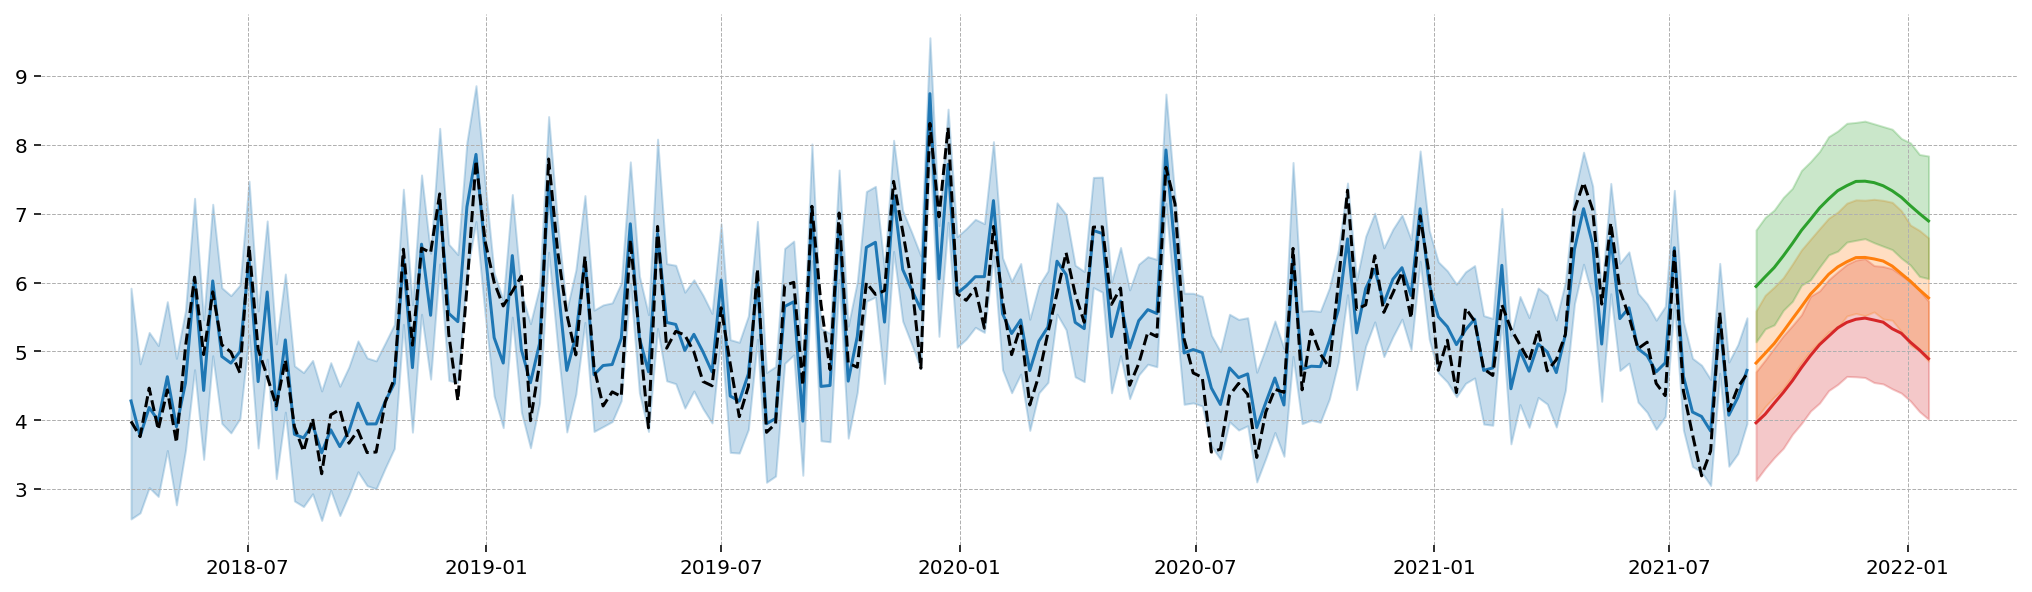

In [44]:
ax = plot_timeseries_posterior(idata_post.predicted_posterior_observed.isel(observed_state=0), data=data.y)
ax = plot_timeseries_posterior(forecast_idata_1.forecast_observed.isel(observed_state=0), ax=ax, color='tab:red')
ax = plot_timeseries_posterior(forecast_idata_2.forecast_observed.isel(observed_state=0), ax=ax, color='tab:orange')
ax = plot_timeseries_posterior(forecast_idata_3.forecast_observed.isel(observed_state=0), ax=ax, color='tab:green')

plt.show()